# **Netflix Show Clustering with K-Means**  

**Hierarchy**: Genre ➜ Rating + Duration ➜ Duration

**Data source**: TMDB “discover” endpoint (watch-provider id = 8 → Netflix)  
**Tech Stack**: Python • Pandas • Scikit-learn • Seaborn • Matplotlib  


**Install Libraries**

In [ ]:
!pip install requests tqdm python-dotenv numpy pandas scikit-learn seaborn matplotlib

**1 Setup & imports**

In [89]:
import os, requests, math, json, warnings
from pathlib import Path
from tqdm.notebook import tqdm

os.environ["OMP_NUM_THREADS"] = "1"                                       # ← prevents the MKL mismatch
warnings.filterwarnings("ignore",
                        message="KMeans is known to have a memory leak on Windows with MKL.*",
                        category=UserWarning,
                        module="sklearn.cluster._kmeans")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

np.random.seed(42)
plt.rcParams["figure.dpi"] = 110

# ---------- DATA ACQUISITION ----------

**2 Pull UK Netflix movies via TMDB API**

In [67]:
TMDB_KEY = os.getenv("TMDB_API_KEY")
BASE_URL = "https://api.themoviedb.org/3"
PROVIDER  = 8          # Netflix
REGION    = "GB"       # United Kingdom
PAGES     = 285        # 285 pages of Netflix UK titles

In [68]:
def tmdb(endpoint: str, **params):
    """Tiny TMDB GET wrapper"""
    params["api_key"] = TMDB_KEY
    r = requests.get(f"{BASE_URL}{endpoint}", params=params, timeout=30)
    r.raise_for_status()
    return r.json()

Discover movie IDs available on UK Netflix

In [69]:
ids = []
for page in tqdm(range(1, PAGES + 1), desc="Discover pages"):
    data = tmdb(
        "/discover/movie",
        watch_region=REGION,
        with_watch_providers=PROVIDER,
        page=page,
        sort_by="popularity.desc",
    )
    ids.extend([m["id"] for m in data["results"]])
    if page >= data["total_pages"]:
        break

print(f"Collected {len(ids):,} titles")

Discover pages:   0%|          | 0/285 [00:00<?, ?it/s]

Collected 5,655 titles


Fetch title-level details (runtime, genres, rating certificate)

In [70]:
def extract_certification(release_dates, country="UK"):
    for block in release_dates.get("results", []):
        if block["iso_3166_1"] == country:
            for entry in block["release_dates"]:
                if entry["certification"]:
                    return entry["certification"]
    return None

records = []
for mid in tqdm(ids, desc="Movie details"):
    d = tmdb(f"/movie/{mid}", append_to_response="release_dates")
    records.append(
        {
            "title":        d["title"],
            "genres":       [g["name"] for g in d["genres"]],
            "rating":       extract_certification(d["release_dates"]),
            "duration_min": d["runtime"] or np.nan,
        }
    )

Movie details:   0%|          | 0/5655 [00:00<?, ?it/s]

In [71]:
df = pd.DataFrame(records).dropna(subset=["genres", "duration_min"]).reset_index(drop=True)
print(f"Netflix UK catalogue pulled: {len(df):,} titles")

Netflix UK catalogue pulled: 5,481 titles


In [72]:
df

,title,genres,rating,duration_min
0,The Old Guard 2,"[Action, Fantasy]",None,107.0
1,KPop Demon Hunters,"[Animation, Fantasy, Action, Comedy, Music]",None,96.0
2,Squid Game: Fireplace,[],None,60.0
3,STRAW,"[Thriller, Drama, Crime]",None,105.0
4,Squid Game in Conversation,[Documentary],None,33.0
...,...,...,...,...
5476,My Beacon of Hope,[],None,81.0
5477,Longboarding LA to NY,[Documentary],None,53.0
5478,Grave of the Fireflies,"[Animation, Drama, War]",None,89.0
5479,Costco vs The Supermarket: Who Does Bulk Buy B...,[Documentary],None,43.0


# ---------- FEATURE ENGINEERING ----------

**3 Genre & rating one-hot, duration scaling**

Multi-label genre OHE

In [73]:
mlb = MultiLabelBinarizer()
genre_ohe = pd.DataFrame(
    mlb.fit_transform(df["genres"]),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index,
)

Rating one-hot

In [74]:
ohe = OneHotEncoder(sparse=False, dtype=np.int8, handle_unknown="ignore")
rating_ohe = pd.DataFrame(
    ohe.fit_transform(df[["rating"]]),
    columns=[f"rating_{c}" for c in ohe.categories_[0]],
    index=df.index,
)

Scaled duration

In [75]:
scaler = StandardScaler()
df["duration_scaled"] = scaler.fit_transform(df[["duration_min"]])

Unified feature matrix

In [76]:
features = pd.concat(
    [genre_ohe, rating_ohe, df[["duration_scaled"]]],
    axis=1,
)
print("Feature matrix shape:", features.shape)

Feature matrix shape: (5481, 21)


# ---------- HIERARCHICAL K-MEANS ----------

**4 Parameters**

We cluster in **three layers** (tweak K’s if you like):

| Layer | Feature space           | K |
|-------|-------------------------|---|
| 1     | Genre one-hot           | 8 |
| 2     | Rating + duration       | 4 |
| 3     | Duration only           | 2 |

In [77]:
K1_GENRE, K2_RATE, K3_DUR = 8, 4, 2
SEED = 42

**5 Layer 1 – genre clusters**

In [78]:
gcols = [c for c in features.columns if c.startswith("genre_")]
k1 = KMeans(n_clusters=K1_GENRE, random_state=SEED, n_init="auto", algorithm="lloyd")
df["C1_genre"] = k1.fit_predict(features[gcols])
df["C1_genre"].value_counts().sort_index()

C1_genre
0     502
1    1282
2     348
3     908
4     543
5     441
6     473
7     984
Name: count, dtype: int64

**6 Layer 2 – rating + duration inside each genre-cluster**

In [90]:
rat_cols = [c for c in features.columns if c.startswith("rating_")]

for g in sorted(df["C1_genre"].unique()):
    idx  = df["C1_genre"] == g
    Xsub = pd.concat(
        [features.loc[idx, rat_cols], df.loc[idx, ["duration_scaled"]]],
        axis=1,
    )
    k2 = KMeans(n_clusters=K2_RATE, random_state=SEED, n_init="auto", algorithm="lloyd")
    df.loc[idx, "C2_rate"] = k2.fit_predict(Xsub).astype(int)

df.groupby(["C1_genre", "C2_rate"]).size().unstack(fill_value=0).head()

C2_rate,0.0,1.0,2.0,3.0
C1_genre,,,,
0,167,80,26,229
1,520,195,517,50
2,195,6,30,117
3,245,195,364,104
4,108,205,228,2


**7 Layer 3 – duration split inside each (genre × rating)**

In [91]:
for g, r in (
    df[["C1_genre", "C2_rate"]]
      .drop_duplicates()
      .itertuples(index=False, name=None)
):
    idx = (df["C1_genre"] == g) & (df["C2_rate"] == r)
    Xsub = df.loc[idx, ["duration_scaled"]]

    if len(Xsub) < K3_DUR:          # tiny subgroup → single bucket
        df.loc[idx, "C3_dur"] = 0
        continue

    k3 = KMeans(n_clusters=K3_DUR, random_state=SEED, n_init="auto", algorithm="lloyd")
    df.loc[idx, "C3_dur"] = k3.fit_predict(Xsub).astype(int)

# Full hierarchical label
df["label"] = (
    "G" + df["C1_genre"].astype(str) + 
    "_R" + df["C2_rate"].astype(str) + 
    "_D" + df["C3_dur"].astype(str)
)

In [81]:
df

,title,genres,rating,duration_min,duration_scaled,C1_genre,C2_rate,C3_dur,label
0,The Old Guard 2,"[Action, Fantasy]",None,107.0,0.390504,5,0.0,0.0,G5_R0.0_D0.0
1,KPop Demon Hunters,"[Animation, Fantasy, Action, Comedy, Music]",None,96.0,0.028714,5,0.0,1.0,G5_R0.0_D1.0
2,Squid Game: Fireplace,[],None,60.0,-1.155327,6,3.0,1.0,G6_R3.0_D1.0
3,STRAW,"[Thriller, Drama, Crime]",None,105.0,0.324724,4,1.0,0.0,G4_R1.0_D0.0
4,Squid Game in Conversation,[Documentary],None,33.0,-2.043357,3,3.0,0.0,G3_R3.0_D0.0
...,...,...,...,...,...,...,...,...,...
5476,My Beacon of Hope,[],None,81.0,-0.464637,6,3.0,0.0,G6_R3.0_D0.0
5477,Longboarding LA to NY,[Documentary],None,53.0,-1.385557,3,1.0,0.0,G3_R1.0_D0.0
5478,Grave of the Fireflies,"[Animation, Drama, War]",None,89.0,-0.201517,1,0.0,0.0,G1_R0.0_D0.0
5479,Costco vs The Supermarket: Who Does Bulk Buy B...,[Documentary],None,43.0,-1.714457,3,1.0,1.0,G3_R1.0_D1.0


# ---------- VISUALISATIONS ----------

**8 PCA scatter coloured by full label**

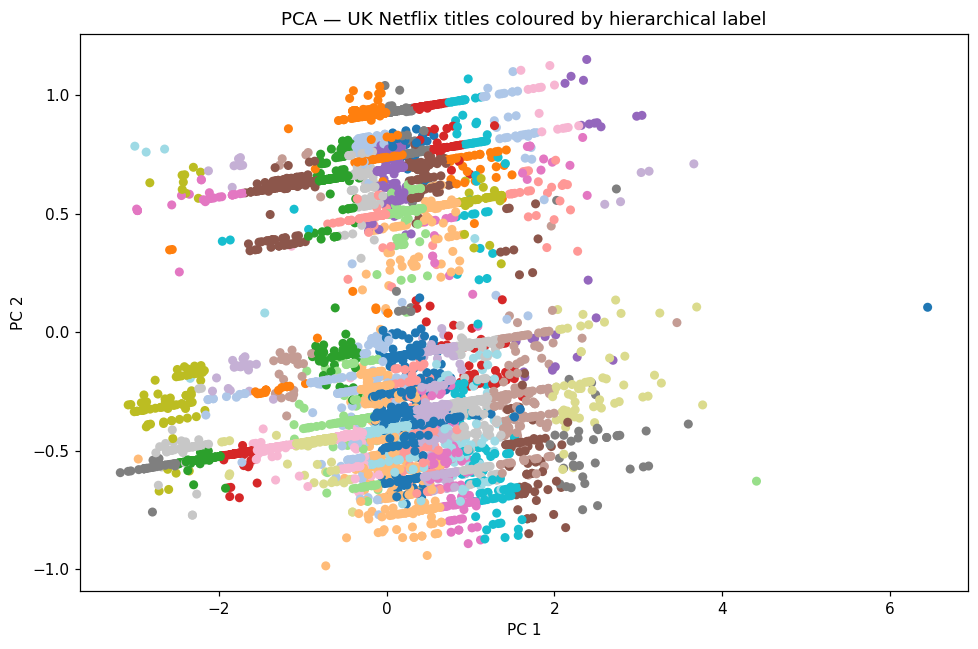

In [82]:
pca = PCA(n_components=2, random_state=SEED)
coords = pca.fit_transform(features)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    x=coords[:, 0], y=coords[:, 1],
    hue=df["label"], palette="tab20", s=35, linewidth=0, legend=False
)
plt.title("PCA — UK Netflix titles coloured by hierarchical label")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

**9 Interactive sunburst (genre → rating → duration)**

In [83]:
fig = px.sunburst(
    df,
    path=["C1_genre", "C2_rate", "C3_dur"],
    title="Genre → Rating → Duration hierarchy",
    color="C1_genre",
    color_continuous_scale="Agsunset",
    maxdepth=-1,
)
fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
fig.show()